In [2]:
import casadi as cs
import numpy as np
import matplotlib.pyplot as plt
import sys
import functools

loc = 'alien-windows'
if loc == 'alien-windows':
    src_root = "C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\src\\"
else:
    raise AssertionError
    
if src_root not in sys.path:
    sys.path.append(src_root)
print(sys.path)
%load_ext autoreload
%autoreload 2

from ds_utils import utils as ds_utils
from models import utils as models
from models import gp_wrappers as gp_wrappers
from smpc import utils as smpc
from smpc import controller_utils as controller
from sys_dyn import problem_setups
from sys_dyn import nlsys_utils as nlsys_utils
from smpc import rt_hgpmpc as rt_hgpmpc
from smpc import full_example_setup as full_example_setup
from mapping import example as hm_mapping
from mapping import nn_map
from exploration_opt import utils as exploration_utils
from exploration_opt import simd_annealing
from common import data_save_utils
from incremental_controller_impls import examples
from incremental_controller_impls import minlp_examples

['C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\ipynb_tests', 'C:\\Program Files\\Python38\\python38.zip', 'C:\\Program Files\\Python38\\DLLs', 'C:\\Program Files\\Python38\\lib', 'C:\\Program Files\\Python38', 'C:\\Users\\l8souza\\PycharmProjects\\GP4MPC\\venv', '', 'C:\\Users\\l8souza\\PycharmProjects\\GP4MPC\\venv\\lib\\site-packages', 'C:\\Users\\l8souza\\PycharmProjects\\GP4MPC\\venv\\lib\\site-packages\\win32', 'C:\\Users\\l8souza\\PycharmProjects\\GP4MPC\\venv\\lib\\site-packages\\win32\\lib', 'C:\\Users\\l8souza\\PycharmProjects\\GP4MPC\\venv\\lib\\site-packages\\Pythonwin', 'C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\src\\']


`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


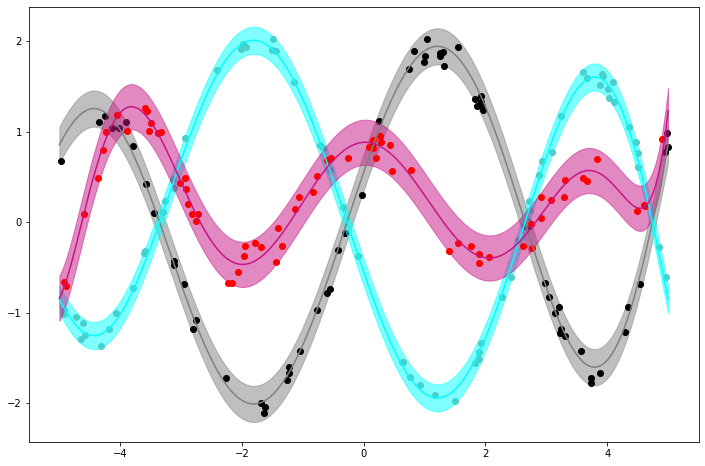

In [3]:
velocity_override = 5
setup_inst = problem_setups.quad_2d_sys_1d_inp_res(velocity_override)
regions = setup_inst["regions"]
s_start_limit, s_end_limit = setup_inst["x_start_limit"], setup_inst["x_end_limit"]
gp_input_mask = setup_inst["gp_input_mask"]
delta_input_mask = setup_inst["delta_input_mask"]
n_u = setup_inst["n_u"]
num_samples = 200
viz = True
noise_std_devs = [0.05, 0.07, 0.02]
scale_poly = 1
noise_std_devs = [0.1, 0.075, 0.125]
# noise_std_devs = [0.1, 0.075, 0.125]
scale_poly = 4

# 0 idx is np.polynomial.polynomial.polyfromroots([-0.2, -0.05, 0, 0.2]), 1 idx is np.polynomial.polynomial.polyfromroots([-0.25, -0.05, 0.15, 0.23])
poly_coeffs = [np.array([0.0075, -0.0425, -0.2   ,  1.][::-1])*5, 
               np.array([0.04, -0.22, -0.1 ,  1.    ][::-1])*5, np.array([4.3125e-04,  5.6000e-03, -6.7000e-02, -8.0000e-02,  1.0000e+00][::-1])*5]
poly_coeffs = [np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               -np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               np.array([3.48167424e-05,  2.29572396e-05, -1.92304178e-03, -5.29264039e-04,  3.35480619e-02,  5.82899495e-04, -1.87669116e-01,  9.30450457e-03,  2.20458632e-01])]
# poly_coeffs = [[1, 0, 0], [7, 0, 0]]

ds_inst_in = ds_utils.test_1d_op_1d_inp_poly(regions=regions, poly_coeffs=poly_coeffs,
                                             start_limit=setup_inst["gpinp_subset_lim_lb"], end_limit=setup_inst["gpinp_subset_lim_ub"], gp_input_mask=gp_input_mask,
                                             delta_input_mask=delta_input_mask, n_u=n_u, num_points=num_samples,
                                             noise_vars=[noise_std_dev ** 2 for noise_std_dev in noise_std_devs],
                                             no_viz=not viz, fineness_param=(200,), scale_poly=scale_poly)

C:\Users\l8souza\PycharmProjects\GPMPC_HM\src\models\utils.py:261: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  region_idx_labels = train_y[dim_idx, regionwise_sample_idxs[region_idx]]


Training piecewise GP
Training model: 1 for region: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 230.23it/s]


final loss: -0.4183275103569031, lengthscale: 1.39796 noise variance (sigma**2): 0.00884, noise std dev (sigma): 0.09402
Training model: 1 for region: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 231.80it/s]


final loss: -0.6803374290466309, lengthscale: 1.72341 noise variance (sigma**2): 0.00512, noise std dev (sigma): 0.07154
Training model: 1 for region: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 253.30it/s]


final loss: -0.172193244099617, lengthscale: 0.51407 noise variance (sigma**2): 0.01318, noise std dev (sigma): 0.11482


C:\Users\l8souza\PycharmProjects\GPMPC_HM\src\models\utils.py:219: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  i_dim_labels = train_y[idx, :].T
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 197.64it/s]


final loss: 1.4995607137680054, lengthscale: 0.53486 noise variance (sigma**2): 1.13433, noise std dev (sigma): 1.06505
Training global GP


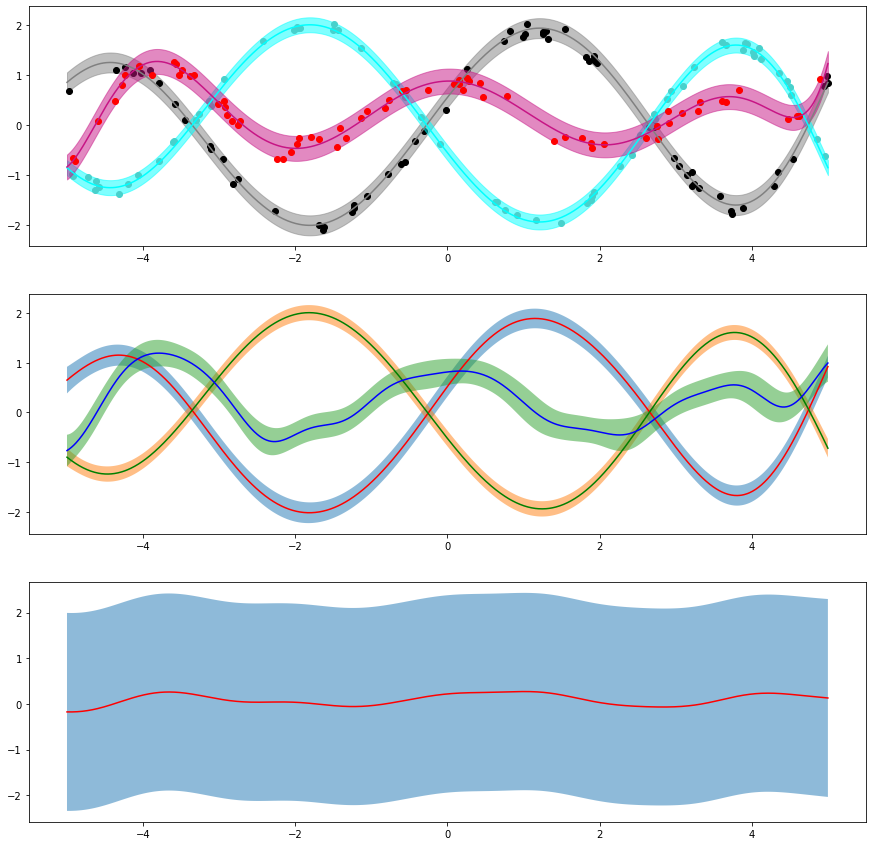

In [5]:
trained_gp_viz = True
train_verbose = True
return_error_attrs = False
seed = None
fineness_param = (75,)
num_iter = 350
true_only = False
terminate_by_change = False
save_to_file = False
load_from_file = False
file_save_name = "res_1d_poly_gp"
file_load_name = "res_1d_poly_gp"

pw_gp_wrapped, global_gp_wrapped, gp_ds_inst = gp_wrappers.train_global_n_pw(ds_inst_in, regions, viz=trained_gp_viz, verbose=train_verbose, return_error_attrs=return_error_attrs,
                                                                             seed=seed, fineness_param=fineness_param, num_iter=num_iter, true_only=true_only,
                                                                             terminate_by_change=terminate_by_change, save_to_file=save_to_file, load_from_file=load_from_file,
                                                                             file_save_name=file_save_name, file_load_name=file_load_name)

## Edge track plots LTI

In [92]:
import pickle as pkl 
Q_override = np.eye(2)*25
Q_override[0, 0] = 75
R_override = np.eye(2)*0.01

sys_config_dict = examples.gpmpc_D_controller(satisfaction_prob=0.99, gp_fns=pw_gp_wrapped, x_init=np.zeros((2, 1)), N=100, closed_loop=True,
                             num_discrete=100, simulation_length=100, velocity_override=7, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=100 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((6, 0), (6, 6), (0, 6), (0, 0)), simulation_length_override=None,
                             problem_setup_fn=problem_setups.planar_lti_1d_inp_res, track_gen_fn=nlsys_utils.test_planar_lti_track,
                             integration_method='exact', online_N=30, read_desired_from_file="lti_dt100msN100disc100xz4_edgetrack",
                             Q_override=Q_override, R_override=R_override, ret_config_dict=True)

file_names = ["final_MINLP_lti_runs_dt100msN100disc100xz4_edgetrack_px99", "final_D_lti_runs_dt100msN100disc100xz4_edgetrack_px99", "final_QP_lti_runs_dt100msN100disc100xz4_edgetrack_px99",
              "final_MINLP_lti_runs_dt100msN100disc100xz4_edgetrack_px9", "final_D_lti_runs_dt100msN100disc100xz4_edgetrack_px9", "final_QP_lti_runs_dt100msN100disc100xz4_edgetrack_px9"]

# file_names = ["final_D_lti_runs_dt100msN100disc100xz4_edgetrack_px99", "final_QP_lti_runs_dt100msN100disc100xz4_edgetrack_px99",
              # "final_D_lti_runs_dt100msN100disc100xz4_edgetrack_px9", "final_QP_lti_runs_dt100msN100disc100xz4_edgetrack_px9"]

idx_to_plot = 7
trajs_to_plot = []
for file_name in file_names:
    with open("C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\src\\data_dir\\"+file_name+".pkl", 'rb') as f:
        data = pkl.load(f)
        cost = np.array([run_data["cl_cost"].item() for run_data in data])
        data_dicts_cl = [run_data["data_dict_cl"] for run_data in data]
        trajs_to_plot.append(data_dicts_cl[idx_to_plot])
        
desired_traj_data = data_save_utils.read_data(file_name="lti_dt100msN100disc100xz4_edgetrack")
x_desired = desired_traj_data["x_desired"]
u_desired = desired_traj_data["u_desired"]
n_u, n_x = 2, 2
u_desired = np.array(u_desired, ndmin=2).reshape((n_u, -1))
tracking_matrix = sys_config_dict["tracking_matrix"]
waypoints_to_track = tracking_matrix[:, :n_x] @ x_desired

[[0 1 0 0]]
[[1]
 [0]]


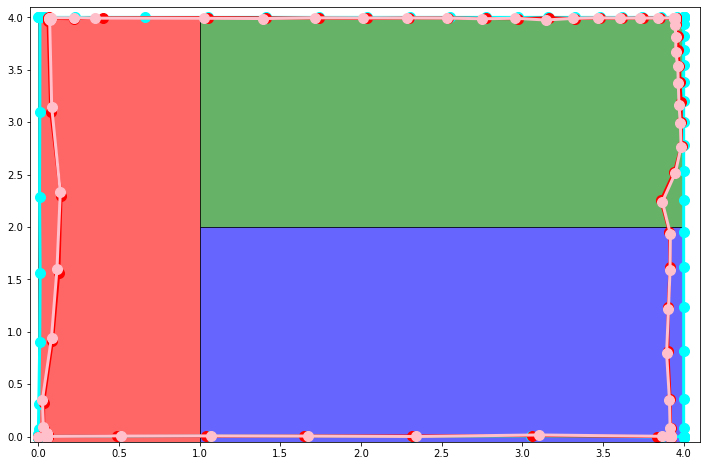

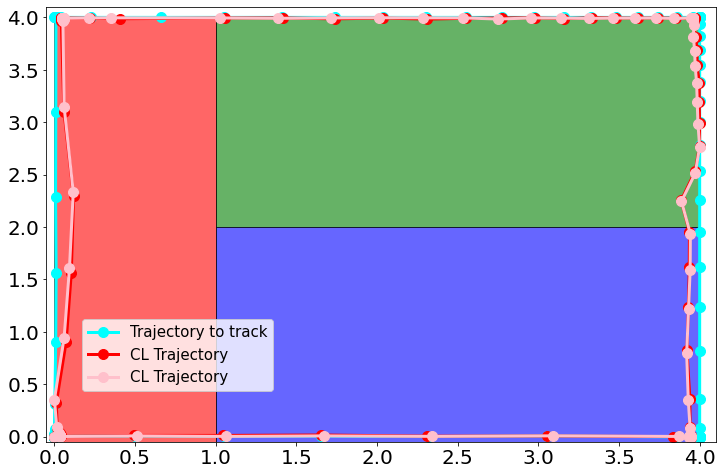

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x1_threshold", "x2_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']

trajs_to_plot_1 = trajs_to_plot[:len(trajs_to_plot)//2]
for idx, data_dict_cl in enumerate(trajs_to_plot_1):
    if idx == 0:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=waypoints_to_track,
                                                data_dict_cl=data_dict_cl,
                                                ret_mu_x_cl=True,
                                                state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                                plot_ol_traj=False, axes=[ax],
                                                ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                                ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                                legend_loc=None,
                                                regions=sys_config_dict["regions"], ignore_legend=True,
                                             colour=colours[idx])
    else:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=None,
                                        data_dict_cl=data_dict_cl,
                                        ret_mu_x_cl=True,
                                        state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                        plot_ol_traj=False, axes=[ax],
                                        ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                        ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                        legend_loc=None,
                                        regions=None, ignore_legend=True, colour=colours[idx])
        
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x1_threshold", "x2_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']
label_text = ["CNLPENDO", "CNLPEXO"]

trajs_to_plot_2 = trajs_to_plot[len(trajs_to_plot)//2:]
for idx, data_dict_cl in enumerate(trajs_to_plot_2):
    if idx == 0:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=waypoints_to_track,
                                                data_dict_cl=data_dict_cl,
                                                ret_mu_x_cl=True,
                                                state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                                plot_ol_traj=False, axes=[ax],
                                                ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                                ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                                legend_loc=None,
                                                regions=sys_config_dict["regions"], ignore_legend=True,
                                             colour=colours[idx])
    else:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=None,
                                        data_dict_cl=data_dict_cl,
                                        ret_mu_x_cl=True,
                                        state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                        plot_ol_traj=False, axes=[ax],
                                        ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                        ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                        legend_loc=None,
                                        regions=None, ignore_legend=True, colour=colours[idx])

ax.legend(loc="lower right", bbox_to_anchor=(0.2, 0.1, 0.15, 0.15), fontsize=15)
        
from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='edge_tracking_lti_final', tick_sizes=20, tick_skip=1, k_range=None)

[0.      0.01512 0.01655 0.00438 0.00163 0.00899 0.01726 0.05915 0.05629
 0.05906 0.0613  0.05728 0.05369 0.05366 0.05103 0.05268 0.05592 0.05735
 0.06799 0.07751 0.06998 0.06327 0.06104 0.11463 0.03111 0.00514 0.00324
 0.00775 0.00846 0.01117 0.02503 0.02824 0.03252 0.03906 0.03677 0.03705
 0.03739 0.03705 0.03976 0.03721 0.03677 0.00477 0.00725 0.0053  0.00507
 0.00584 0.00202 0.00366 0.00367 0.00366 0.0071  0.01076 0.00824 0.0073
 0.00737 0.05535 0.03538 0.00408 0.00862 0.02613 0.03031 0.03224 0.03912
 0.04222 0.03378 0.03544 0.03371 0.04649 0.03989 0.04006 0.04184 0.04171
 0.03339 0.04876 0.05142 0.11588 0.09707 0.06425 0.01552 0.01819 0.03114
 0.03759 0.03353 0.03376 0.03672 0.03717 0.037   0.03551 0.03541 0.03909
 0.04028 0.03761 0.03509 0.03992 0.03444 0.04148 0.03761 0.03527 0.0377
 0.03566]
[0.      0.00994 0.01056 0.01044 0.01463 0.00324 0.02451 0.05276 0.05954
 0.05527 0.05543 0.05311 0.05852 0.06081 0.06595 0.06579 0.05839 0.06594
 0.06707 0.08106 0.06993 0.06476 0.064   0.

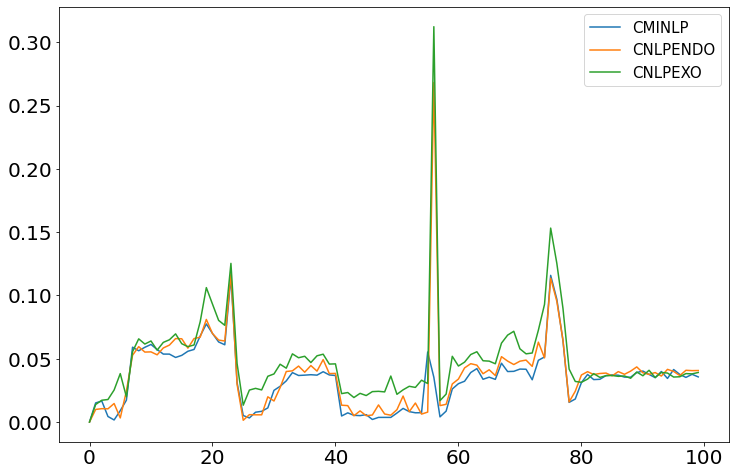

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x1_threshold", "x2_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']
label_text = ["CMINLP", "CNLPENDO", "CNLPEXO"]

trajs_to_plot_1 = trajs_to_plot[len(trajs_to_plot)//2:]
for idx, data_dict_cl in enumerate(trajs_to_plot_1):
    mu_x_cl = np.hstack([data_dict_ol['mu_x'][:, [0]] for data_dict_ol in data_dict_cl])
    # print(mu_x_cl[:, 0])
    np_abs = np.abs(mu_x_cl - waypoints_to_track[:, :mu_x_cl.shape[-1]])
    abs_dev = np.sum(np_abs, axis=0)
    print(abs_dev)
    ax.plot(range(mu_x_cl.shape[-1]), abs_dev, label=label_text[idx])
    
ax.legend(loc="upper right", fontsize=15)
    

        
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# limiter_names = ["x1_threshold", "x2_threshold"]
# # data_dict_cl = data_dicts_cl[3]
# colours = ['r', 'pink', 'g']
# label_text = ["CNLPENDO", "CNLPEXO"]

# ax.legend(loc="lower right", bbox_to_anchor=(0.2, 0.1, 0.15, 0.15), fontsize=15)
        
# from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='edge_tracking_lti_final_abs_error', tick_sizes=20, tick_skip=1, k_range=None)

## Figure-8 plots LTI

In [94]:
import pickle as pkl 

Q_override=np.eye(2)*50
sys_config_dict = examples.gpmpc_D_controller(gp_fns=pw_gp_wrapped, x_init=np.zeros((2, 1)), N=100, closed_loop=True,
                             num_discrete=100, simulation_length=100, velocity_override=5, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=100 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((6, 0), (6, 6), (0, 6), (0, 0)), simulation_length_override=None,
                             problem_setup_fn=problem_setups.planar_lti_1d_inp_res, track_gen_fn=nlsys_utils.test_planar_lti_track,
                             integration_method='exact', online_N=30, read_desired_from_file="lti_dt100msN100disc100xz4_interiortrack",
                             Q_override=Q_override, ret_config_dict=True)

# file_names = ["final_MINLP_lti_runs_dt100msN100disc100xz4_edgetrack_px99", "final_D_lti_runs_dt100msN100disc100xz4_edgetrack_px99", "final_QP_lti_runs_dt100msN100disc100xz4_edgetrack_px99",
#               "final_MINLP_lti_runs_dt100msN100disc100xz4_edgetrack_px9", "final_D_lti_runs_dt100msN100disc100xz4_edgetrack_px9", "final_QP_lti_runs_dt100msN100disc100xz4_edgetrack_px9"]

file_names = ["final_lti_MINLP_dt100msN100disc100xz4_interiortrack", "final_lti_C_runs_dt100msN100disc100xz4_interiortrack", "final_lti_QP_runs_dt100msN100disc100xz4_interiortrack"]

idx_to_plot = 7
trajs_to_plot = []
for file_name in file_names:
    with open("C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\src\\data_dir\\"+file_name+".pkl", 'rb') as f:
        data = pkl.load(f)
        cost = np.array([run_data["cl_cost"].item() for run_data in data])
        data_dicts_cl = [run_data["data_dict_cl"] for run_data in data]
        trajs_to_plot.append(data_dicts_cl[idx_to_plot])
        
desired_traj_data = data_save_utils.read_data(file_name="lti_dt100msN100disc100xz4_interiortrack")
x_desired = desired_traj_data["x_desired"]
u_desired = desired_traj_data["u_desired"]
n_u, n_x = 2, 2
u_desired = np.array(u_desired, ndmin=2).reshape((n_u, -1))
tracking_matrix = sys_config_dict["tracking_matrix"]
waypoints_to_track = tracking_matrix[:, :n_x] @ x_desired

[[0 1 0 0]]
[[1]
 [0]]


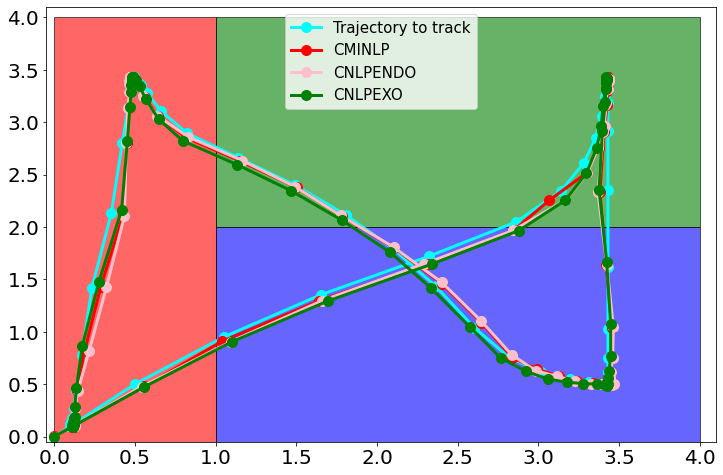

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x1_threshold", "x2_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']
label_text = ["CMINLP", "CNLPENDO", "CNLPEXO"]

for idx, data_dict_cl in enumerate(trajs_to_plot):
    if idx == 0:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=waypoints_to_track,
                                                data_dict_cl=data_dict_cl,
                                                ret_mu_x_cl=True,
                                                state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                                plot_ol_traj=False, axes=[ax],
                                                ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                                ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                                legend_loc=None, label=label_text[idx],
                                                regions=sys_config_dict["regions"], ignore_legend=True,
                                             colour=colours[idx])
    else:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=None,
                                        data_dict_cl=data_dict_cl,
                                        ret_mu_x_cl=True,
                                        state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                        plot_ol_traj=False, axes=[ax],
                                        ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                        ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                        legend_loc=None, label=label_text[idx],
                                        regions=None, ignore_legend=True, colour=colours[idx])
        
ax.legend(loc="upper center", fontsize=15)

from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='figure8_tracking_lti_final', tick_sizes=20, tick_skip=1, k_range=None)

[0.0021  0.08019 0.04946 0.07243 0.07523 0.094   0.15655 0.11014 0.11333
 0.11694 0.10715 0.02117 0.00795 0.00557 0.00317 0.00239 0.00308 0.00082
 0.00527 0.00385 0.00566 0.02108 0.01771 0.02899 0.06831 0.03035 0.03099
 0.02604 0.02621 0.00504 0.00321 0.00787 0.0026  0.00274 0.00593 0.00738
 0.00253 0.00222 0.00103 0.00121 0.00055 0.00991 0.03495 0.08984 0.09913
 0.05833 0.01796 0.09323 0.06301 0.014   0.039   0.03488 0.04757 0.04784
 0.06864 0.05081 0.0166  0.01501 0.01037 0.00922 0.00796 0.01416 0.01137
 0.01105 0.01132 0.00966 0.01045 0.01958 0.01587 0.01555 0.01802 0.01044
 0.01172 0.03486 0.10187 0.06029 0.05549 0.0071  0.01176 0.01563 0.02088
 0.0181  0.01805 0.02036 0.02039 0.02364 0.02357 0.01795 0.01841 0.02032
 0.01951 0.02    0.02368 0.01868 0.02031 0.02123 0.02337 0.0208  0.02095
 0.01903]
[0.      0.06536 0.08924 0.06221 0.0977  0.09764 0.11652 0.11439 0.11138
 0.11604 0.09539 0.02704 0.01113 0.00679 0.02024 0.02091 0.00721 0.01336
 0.00846 0.01423 0.00722 0.00362 0.0161  

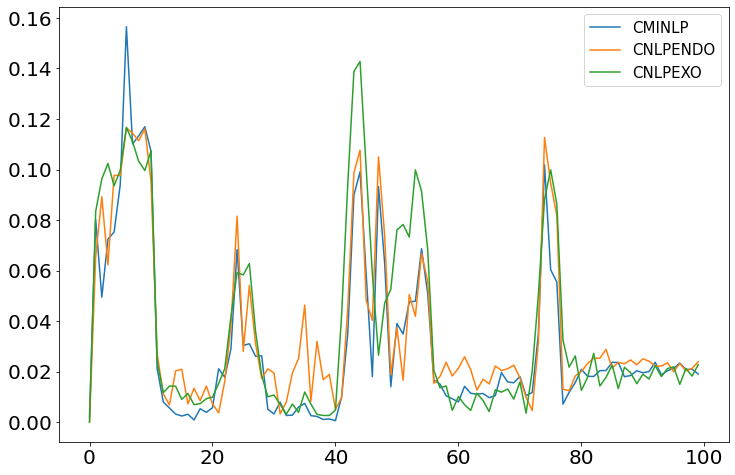

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x1_threshold", "x2_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']
label_text = ["CMINLP", "CNLPENDO", "CNLPEXO"]

for idx, data_dict_cl in enumerate(trajs_to_plot):
    mu_x_cl = np.hstack([data_dict_ol['mu_x'][:, [0]] for data_dict_ol in data_dict_cl])
    # print(mu_x_cl[:, 0])
    np_abs = np.abs(mu_x_cl - waypoints_to_track[:, :mu_x_cl.shape[-1]])
    abs_dev = np.sum(np_abs, axis=0)
    print(abs_dev)
    ax.plot(range(mu_x_cl.shape[-1]), abs_dev, label=label_text[idx])
    
ax.legend(loc="upper right", fontsize=15)
    

        
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# limiter_names = ["x1_threshold", "x2_threshold"]
# # data_dict_cl = data_dicts_cl[3]
# colours = ['r', 'pink', 'g']
# label_text = ["CNLPENDO", "CNLPEXO"]

# ax.legend(loc="lower right", bbox_to_anchor=(0.2, 0.1, 0.15, 0.15), fontsize=15)
        
# from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='figure8_tracking_lti_final_abs_error', tick_sizes=20, tick_skip=1, k_range=None)

In [96]:
print(list(range(0, 30, 10)))

[0, 10, 20]


## Figure-8 plots Quad-2D

In [119]:
import pickle as pkl 

Q_override = np.eye(6)
Q_override[0, 0] = 20
Q_override[2, 2] = 20
R_override = np.eye(2) * 0.01

sys_config_dict = examples.gpmpc_D_controller(satisfaction_prob=0.99, gp_fns=pw_gp_wrapped, x_init=np.zeros((6, 1)), N=100, closed_loop=True,
                             num_discrete=200, simulation_length=200, velocity_override=5, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=50 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((3.5, 3.5), (3.5, 0.5), (0.5, 3.5), (0.1, 0.1)), simulation_length_override=None,
                             integration_method='euler', online_N=30, read_desired_from_file="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority",
                             Q_override=Q_override, R_override=R_override, ret_config_dict=True)

file_names = ["final_quad2d_D_runs_dt50msN100disc200xz4_interiortrack_no_w_pen", "final_quad2d_QP_runs_dt50msN100disc200xz4_interiortrack_no_w_pen"]

idx_to_plot = 20
trajs_to_plot = []
for file_name in file_names:
    with open("C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\src\\data_dir\\"+file_name+".pkl", 'rb') as f:
        data = pkl.load(f)
        cost = np.array([run_data["cl_cost"].item() for run_data in data])
        data_dicts_cl = [run_data["data_dict_cl"] for run_data in data]
        trajs_to_plot.append(data_dicts_cl[idx_to_plot])
        
desired_traj_data = data_save_utils.read_data(file_name="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority")
x_desired = desired_traj_data["x_desired"]
u_desired = desired_traj_data["u_desired"]
n_u, n_x = 2, 6
u_desired = np.array(u_desired, ndmin=2).reshape((n_u, -1))
tracking_matrix = sys_config_dict["tracking_matrix"]
waypoints_to_track = tracking_matrix[:, :n_x] @ x_desired

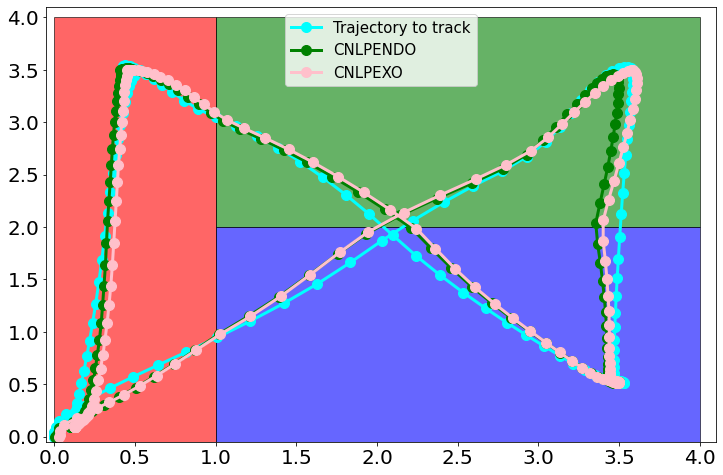

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x_threshold", "z_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['g', 'pink', 'g']
label_text = ["CNLPENDO", "CNLPEXO"]

for idx, data_dict_cl in enumerate(trajs_to_plot):
    if idx == 0:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=waypoints_to_track,
                                                data_dict_cl=data_dict_cl,
                                                ret_mu_x_cl=True,
                                                state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                                plot_ol_traj=False, axes=[ax],
                                                ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                                ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                                legend_loc=None, label=label_text[idx],
                                                regions=sys_config_dict["regions"], ignore_legend=True,
                                             colour=colours[idx])
    else:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=None,
                                        data_dict_cl=data_dict_cl,
                                        ret_mu_x_cl=True,
                                        state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                        plot_ol_traj=False, axes=[ax],
                                        ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                        ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                        legend_loc=None, label=label_text[idx],
                                        regions=None, ignore_legend=True, colour=colours[idx])
        
ax.legend(loc="upper center", fontsize=15)

from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='figure8_tracking_quad2d_final', tick_sizes=20, tick_skip=1, k_range=None)

[0.00168 1.17684 1.43538 1.85452 2.21261 1.61267 1.33862 0.9715  0.82511
 0.82642 0.81467 0.79088 0.84107 1.02651 1.0013  1.00542 1.12317 1.25611
 1.20031 0.98704 0.77799 0.46151 0.76103 1.12671 1.40958 1.71982 1.66812
 1.55457 1.38753 1.19712 1.12994 1.21274 1.33846 1.45565 1.49019 1.52709
 1.39345 1.32453 1.37323 1.27338 1.17464 1.09326 1.08475 1.06166 1.03902
 1.01113 1.05242 1.13664 1.23619 1.22566 1.18729 0.81836 0.78702 0.74792
 0.73342 0.73712 0.7751  0.80326 0.80977 0.83803 0.80099 0.79727 0.79586
 0.76322 0.74199 0.71487 0.67891 0.66601 0.63501 0.60081 0.56985 0.53854
 0.51062 0.48166 0.4636  0.44464 0.43458 0.43332 0.42162 0.40201 0.40007
 0.39974 0.41022 0.39588 0.40225 0.40001 0.36939 0.38887 0.38484 0.36399
 0.36987 0.30898 0.20912 0.32465 0.48494 0.64063 0.78987 0.94547 1.05623
 1.27222 1.33427 1.08246 1.04672 0.99243 0.97517 0.95881 1.02946 0.76371
 0.87562 0.76773 0.67054 0.70768 0.77722 0.80759 0.79842 0.78482 0.72333
 0.66039 0.56721 0.488   0.36401 0.24131 0.18594 0.

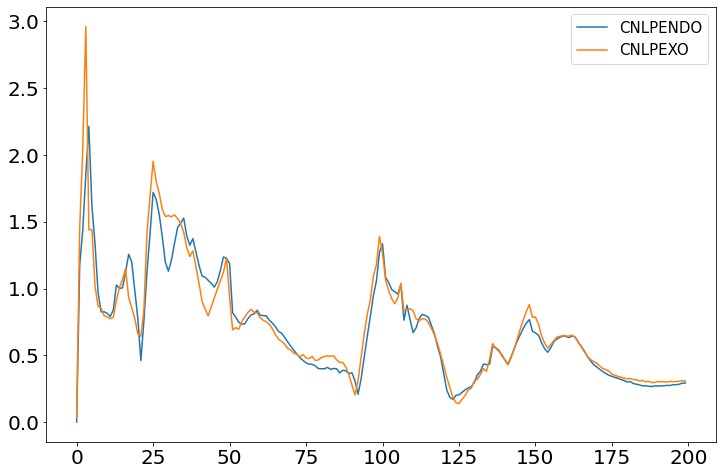

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']
label_text = ["CNLPENDO", "CNLPEXO"]

for idx, data_dict_cl in enumerate(trajs_to_plot):
    mu_x_cl = np.hstack([data_dict_ol['mu_x'][:, [0]] for data_dict_ol in data_dict_cl])
    # print(mu_x_cl[:, 0])
    np_abs = np.abs(mu_x_cl - x_desired[:, :mu_x_cl.shape[-1]])
    abs_dev = np.sum(np_abs, axis=0)
    print(abs_dev)
    ax.plot(range(mu_x_cl.shape[-1]), abs_dev, label=label_text[idx])
    
ax.legend(loc="upper right", fontsize=15)
    

        
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# limiter_names = ["x1_threshold", "x2_threshold"]
# # data_dict_cl = data_dicts_cl[3]
# colours = ['r', 'pink', 'g']
# label_text = ["CNLPENDO", "CNLPEXO"]

# ax.legend(loc="lower right", bbox_to_anchor=(0.2, 0.1, 0.15, 0.15), fontsize=15)
        
# from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='figure8_tracking_quad2d_final_abs_error', tick_sizes=20, tick_skip=1, k_range=None)

[0.00168 1.17684 1.43538 1.85452 2.21261 1.61267 1.33862 0.9715  0.82511
 0.82642 0.81467 0.79088 0.84107 1.02651 1.0013  1.00542 1.12317 1.25611
 1.20031 0.98704 0.77799 0.46151 0.76103 1.12671 1.40958 1.71982 1.66812
 1.55457 1.38753 1.19712 1.12994 1.21274 1.33846 1.45565 1.49019 1.52709
 1.39345 1.32453 1.37323 1.27338 1.17464 1.09326 1.08475 1.06166 1.03902
 1.01113 1.05242 1.13664 1.23619 1.22566 1.18729 0.81836 0.78702 0.74792
 0.73342 0.73712 0.7751  0.80326 0.80977 0.83803 0.80099 0.79727 0.79586
 0.76322 0.74199 0.71487 0.67891 0.66601 0.63501 0.60081 0.56985 0.53854
 0.51062 0.48166 0.4636  0.44464 0.43458 0.43332 0.42162 0.40201 0.40007
 0.39974 0.41022 0.39588 0.40225 0.40001 0.36939 0.38887 0.38484 0.36399
 0.36987 0.30898 0.20912 0.32465 0.48494 0.64063 0.78987 0.94547 1.05623
 1.27222 1.33427 1.08246 1.04672 0.99243 0.97517 0.95881 1.02946 0.76371
 0.87562 0.76773 0.67054 0.70768 0.77722 0.80759 0.79842 0.78482 0.72333
 0.66039 0.56721 0.488   0.36401 0.24131 0.18594 0.

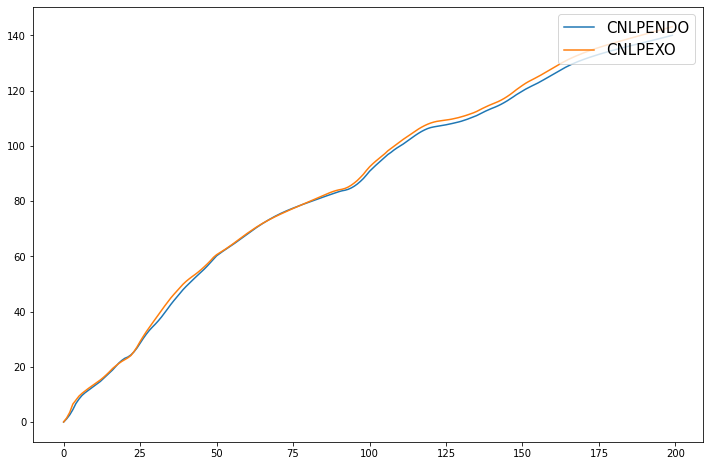

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# data_dict_cl = data_dicts_cl[3]
colours = ['r', 'pink', 'g']
label_text = ["CNLPENDO", "CNLPEXO"]

for idx, data_dict_cl in enumerate(trajs_to_plot):
    mu_x_cl = np.hstack([data_dict_ol['mu_x'][:, [0]] for data_dict_ol in data_dict_cl])
    # print(mu_x_cl[:, 0])
    np_abs = np.abs(mu_x_cl - x_desired[:, :mu_x_cl.shape[-1]])
    abs_dev = np.sum(np_abs, axis=0)
    print(abs_dev)
    # ax.plot(range(mu_x_cl.shape[-1]), abs_dev, label=label_text[idx])
    ax.plot(range(mu_x_cl.shape[-1]), np.cumsum(abs_dev), label=label_text[idx])
    
ax.legend(loc="upper right", fontsize=15)
    

        
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# limiter_names = ["x1_threshold", "x2_threshold"]
# # data_dict_cl = data_dicts_cl[3]
# colours = ['r', 'pink', 'g']
# label_text = ["CNLPENDO", "CNLPEXO"]

# ax.legend(loc="lower right", bbox_to_anchor=(0.2, 0.1, 0.15, 0.15), fontsize=15)
        
# from common.plotting_utils import save_fig
# save_fig(axes=[ax], fig_name='figure8_tracking_quad2d_final_abs_error', tick_sizes=20, tick_skip=1, k_range=None)

## Horizon Comp

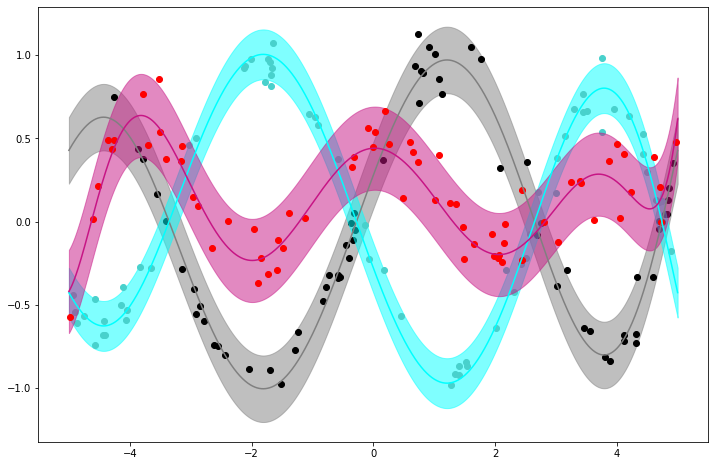

In [125]:
velocity_override = 5
setup_inst = problem_setups.quad_2d_sys_1d_inp_res(velocity_override)
regions = setup_inst["regions"]
s_start_limit, s_end_limit = setup_inst["x_start_limit"], setup_inst["x_end_limit"]
gp_input_mask = setup_inst["gp_input_mask"]
delta_input_mask = setup_inst["delta_input_mask"]
n_u = setup_inst["n_u"]
num_samples = 200
viz = True
noise_std_devs = [0.05, 0.07, 0.02]
scale_poly = 2
noise_std_devs = [0.1, 0.075, 0.125]
# noise_std_devs = [0.1, 0.075, 0.125]
# scale_poly = 2

# 0 idx is np.polynomial.polynomial.polyfromroots([-0.2, -0.05, 0, 0.2]), 1 idx is np.polynomial.polynomial.polyfromroots([-0.25, -0.05, 0.15, 0.23])
poly_coeffs = [np.array([0.0075, -0.0425, -0.2   ,  1.][::-1])*5, 
               np.array([0.04, -0.22, -0.1 ,  1.    ][::-1])*5, np.array([4.3125e-04,  5.6000e-03, -6.7000e-02, -8.0000e-02,  1.0000e+00][::-1])*5]
poly_coeffs = [np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               -np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               np.array([3.48167424e-05,  2.29572396e-05, -1.92304178e-03, -5.29264039e-04,  3.35480619e-02,  5.82899495e-04, -1.87669116e-01,  9.30450457e-03,  2.20458632e-01])]
# poly_coeffs = [[1, 0, 0], [7, 0, 0]]

ds_inst_in = ds_utils.test_1d_op_1d_inp_poly(regions=regions, poly_coeffs=poly_coeffs,
                                             start_limit=setup_inst["gpinp_subset_lim_lb"], end_limit=setup_inst["gpinp_subset_lim_ub"], gp_input_mask=gp_input_mask,
                                             delta_input_mask=delta_input_mask, n_u=n_u, num_points=num_samples,
                                             noise_vars=[noise_std_dev ** 2 for noise_std_dev in noise_std_devs],
                                             no_viz=not viz, fineness_param=(200,), scale_poly=scale_poly)

Training piecewise GP
Training model: 1 for region: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 165.14it/s]


final loss: -0.47769784927368164, lengthscale: 1.42013 noise variance (sigma**2): 0.01065, noise std dev (sigma): 0.10322
Training model: 1 for region: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 177.91it/s]


final loss: -0.6406660079956055, lengthscale: 1.50586 noise variance (sigma**2): 0.00752, noise std dev (sigma): 0.08669
Training model: 1 for region: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 148.14it/s]


final loss: -0.2549470365047455, lengthscale: 1.04199 noise variance (sigma**2): 0.01991, noise std dev (sigma): 0.14112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:13<00:00, 25.13it/s]


final loss: 0.7335304021835327, lengthscale: 0.10753 noise variance (sigma**2): 0.19624, noise std dev (sigma): 0.44300
Training global GP


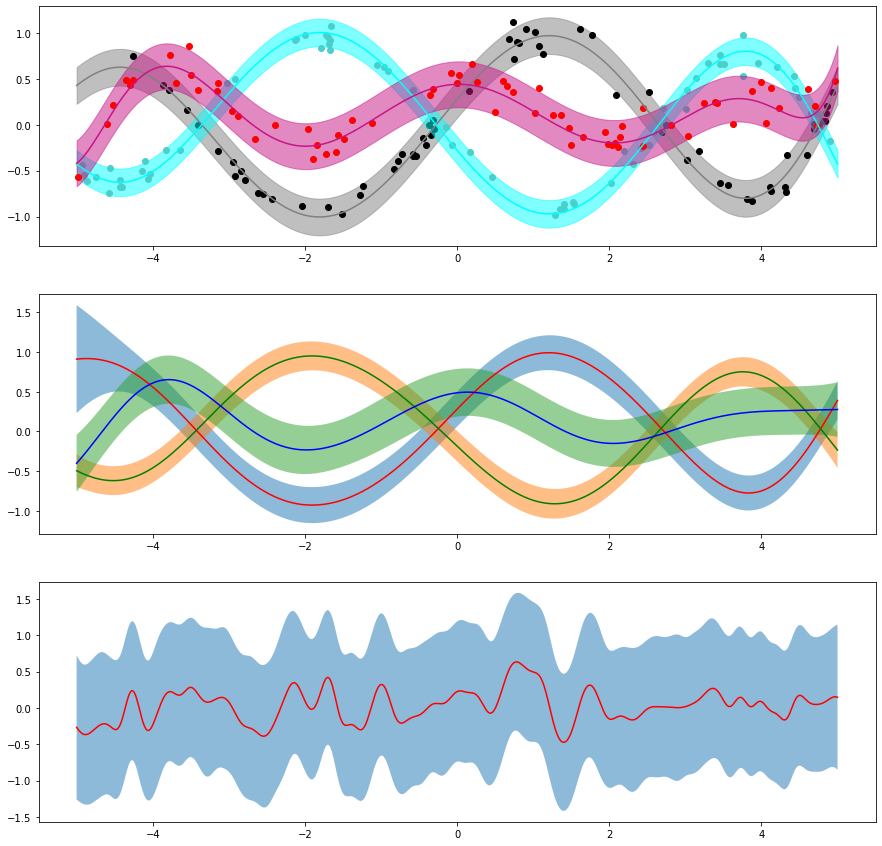

In [126]:
trained_gp_viz = True
train_verbose = True
return_error_attrs = False
seed = None
fineness_param = (75,)
num_iter = 350
true_only = False
terminate_by_change = False
save_to_file = False
load_from_file = False
file_save_name = "res_1d_poly_gp"
file_load_name = "res_1d_poly_gp"

pw_gp_wrapped, global_gp_wrapped, gp_ds_inst = gp_wrappers.train_global_n_pw(ds_inst_in, regions, viz=trained_gp_viz, verbose=train_verbose, return_error_attrs=return_error_attrs,
                                                                             seed=seed, fineness_param=fineness_param, num_iter=num_iter, true_only=true_only,
                                                                             terminate_by_change=terminate_by_change, save_to_file=save_to_file, load_from_file=load_from_file,
                                                                             file_save_name=file_save_name, file_load_name=file_load_name)

NOT SKIPPING SHRINKING.
Shrinking by desired. MAKE SURE YOU HAVE PASSED IN THE MOST UP TO DATE X_DESIRED. This approach is to be used AFTER hlds have been generated since the hlds are used to forward
205
Solving for timestep: 0
t: 0, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.17247 0.22098] Solving for timestep: 1
t: 1, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.29668 0.29544] Solving for timestep: 2
t: 2, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.29668 0.26825] Solving for timestep: 3
t: 3, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.13962 0.11803] Solving for timestep: 4
t: 4, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.05773 0.05707] Solving for timestep: 5
t: 5, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.23658 0.23491] Solving for timestep: 6
t: 6, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.24059 0.23981] Solving for timestep: 7
t: 7, Ret. stat.: Solved_To_Acceptable_Level, Syste

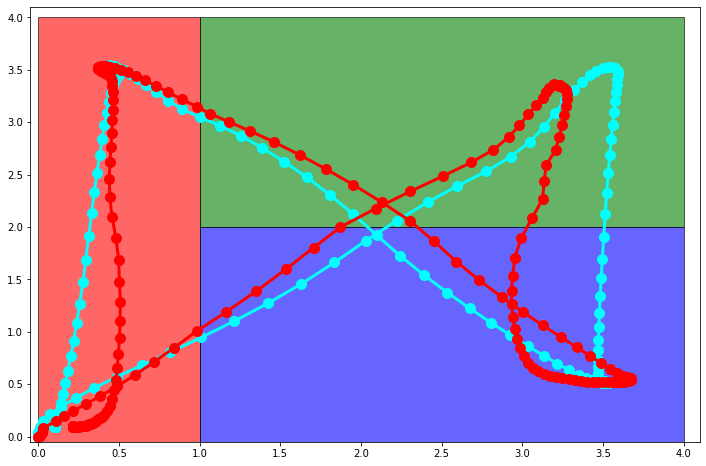

In [129]:
Q_override = np.eye(6)
Q_override[0, 0] = 20
Q_override[2, 2] = 20
R_override = np.eye(2) * 0.01

examples.gpmpc_D_controller(satisfaction_prob=0.99, gp_fns=pw_gp_wrapped, x_init=np.zeros((6, 1)), N=100, closed_loop=True,
                             num_discrete=200, simulation_length=200, velocity_override=5, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=50 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((3.5, 3.5), (3.5, 0.5), (0.5, 3.5), (0.1, 0.1)), simulation_length_override=None,
                             integration_method='euler', online_N=6, read_desired_from_file="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority",
                             Q_override=Q_override, R_override=R_override)

NOT SKIPPING SHRINKING.
Shrinking by desired. MAKE SURE YOU HAVE PASSED IN THE MOST UP TO DATE X_DESIRED. This approach is to be used AFTER hlds have been generated since the hlds are used to forward
215
Solving for timestep: 0
t: 0, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.16282 0.21133] Solving for timestep: 1
t: 1, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.29532 0.29668] Solving for timestep: 2
t: 2, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.29668 0.26921] Solving for timestep: 3
t: 3, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.17091 0.1462 ] Solving for timestep: 4
t: 4, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.05813 0.05634] Solving for timestep: 5
t: 5, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.20517 0.20311] Solving for timestep: 6
t: 6, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.24266 0.24155] Solving for timestep: 7
t: 7, Ret. stat.: Solved_To_Acceptable_Level, Syste

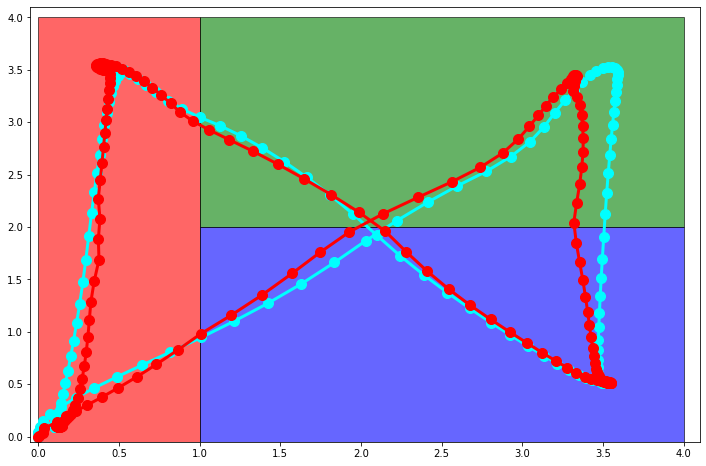

In [130]:
Q_override = np.eye(6)
Q_override[0, 0] = 20
Q_override[2, 2] = 20
R_override = np.eye(2) * 0.01

examples.gpmpc_D_controller(satisfaction_prob=0.99, gp_fns=pw_gp_wrapped, x_init=np.zeros((6, 1)), N=100, closed_loop=True,
                             num_discrete=200, simulation_length=200, velocity_override=5, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=50 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((3.5, 3.5), (3.5, 0.5), (0.5, 3.5), (0.1, 0.1)), simulation_length_override=None,
                             integration_method='euler', online_N=16, read_desired_from_file="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority",
                             Q_override=Q_override, R_override=R_override)

NOT SKIPPING SHRINKING.
Shrinking by desired. MAKE SURE YOU HAVE PASSED IN THE MOST UP TO DATE X_DESIRED. This approach is to be used AFTER hlds have been generated since the hlds are used to forward
223
Solving for timestep: 0
t: 0, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.1642  0.21272] Solving for timestep: 1
t: 1, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.29668 0.29552] Solving for timestep: 2
t: 2, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.29665 0.27039] Solving for timestep: 3
t: 3, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.15083 0.12874] Solving for timestep: 4
t: 4, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.06391 0.0618 ] Solving for timestep: 5
t: 5, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.22347 0.22141] Solving for timestep: 6
t: 6, Ret. stat.: Solved_To_Acceptable_Level, System inputs: [0.23996 0.23873] Solving for timestep: 7
t: 7, Ret. stat.: Solved_To_Acceptable_Level, Syste

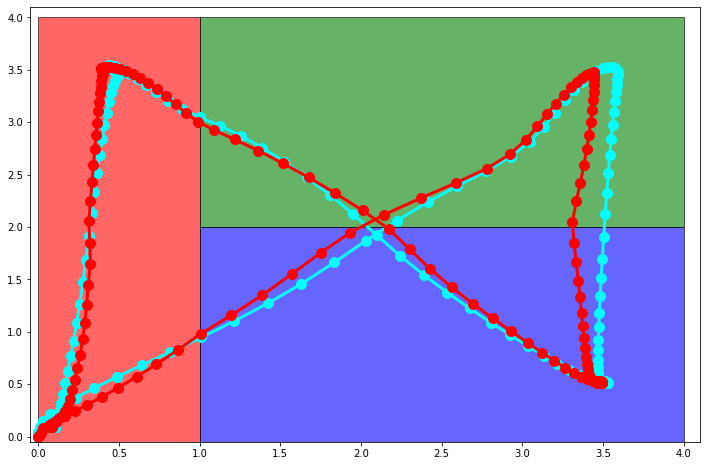

In [131]:
Q_override = np.eye(6)
Q_override[0, 0] = 20
Q_override[2, 2] = 20
R_override = np.eye(2) * 0.01

examples.gpmpc_D_controller(satisfaction_prob=0.99, gp_fns=pw_gp_wrapped, x_init=np.zeros((6, 1)), N=100, closed_loop=True,
                             num_discrete=200, simulation_length=200, velocity_override=5, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=50 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((3.5, 3.5), (3.5, 0.5), (0.5, 3.5), (0.1, 0.1)), simulation_length_override=None,
                             integration_method='euler', online_N=24, read_desired_from_file="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority",
                             Q_override=Q_override, R_override=R_override)

In [136]:
import pickle as pkl 

Q_override = np.eye(6)
Q_override[0, 0] = 20
Q_override[2, 2] = 20
R_override = np.eye(2) * 0.01

sys_config_dict = examples.gpmpc_D_controller(satisfaction_prob=0.99, gp_fns=pw_gp_wrapped, x_init=np.zeros((6, 1)), N=100, closed_loop=True,
                             num_discrete=200, simulation_length=200, velocity_override=5, add_delta_constraints=False, fwd_sim="w_pw_res", true_ds_inst=ds_inst_in,
                             ignore_init_constr_check=True, include_res_in_ctrl=True, collision_check=True,
                             early_termination=True, verbose=False, sampling_time=50 * 1e-3,
                             x_threshold=4, z_threshold=4, x0_delim=1, x1_delim=2, x_min_threshold=0,
                             waypoint_arr=((3.5, 3.5), (3.5, 0.5), (0.5, 3.5), (0.1, 0.1)), simulation_length_override=None,
                             integration_method='euler', online_N=30, read_desired_from_file="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority",
                             Q_override=Q_override, R_override=R_override, ret_config_dict=True)

file_names = ["horizon_qualit_N24", "horizon_qualit_N16", "horizon_qualit_N6"]

idx_to_plot = 0
trajs_to_plot = []
for file_name in file_names:
    with open("C:\\Users\\l8souza\\PycharmProjects\\GPMPC_HM\\src\\data_dir\\"+file_name+".pkl", 'rb') as f:
        data = pkl.load(f)
        # print(data)
        cost = data["cl_cost"].item()
        data_dict_cl = data["data_dict_cl"]
        trajs_to_plot.append(data_dict_cl)
        
desired_traj_data = data_save_utils.read_data(file_name="quad2d_dt50msN100disc200xz4_interiortrack_rdctrl_authority")
x_desired = desired_traj_data["x_desired"]
u_desired = desired_traj_data["u_desired"]
n_u, n_x = 2, 6
u_desired = np.array(u_desired, ndmin=2).reshape((n_u, -1))
tracking_matrix = sys_config_dict["tracking_matrix"]
waypoints_to_track = tracking_matrix[:, :n_x] @ x_desired

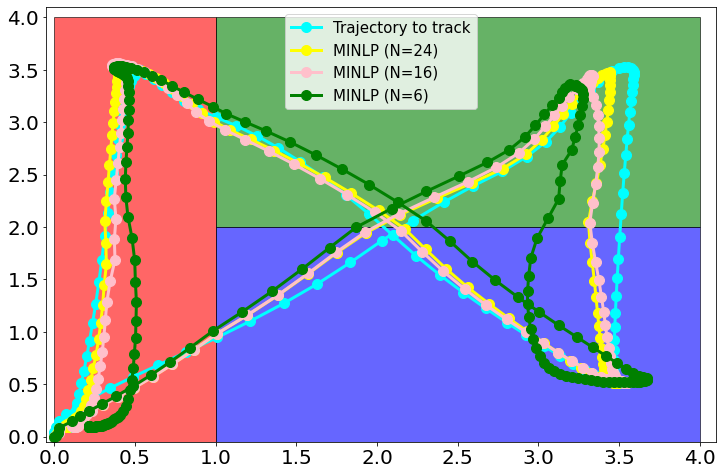

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
limiter_names = ["x_threshold", "z_threshold"]
# data_dict_cl = data_dicts_cl[3]
colours = ['yellow', 'pink', 'g']
label_text = ["MINLP (N=24)", "MINLP (N=16)", "MINLP (N=6)"]

for idx, data_dict_cl in enumerate(trajs_to_plot):
    if idx == 0:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=waypoints_to_track,
                                                data_dict_cl=data_dict_cl,
                                                ret_mu_x_cl=True,
                                                state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                                plot_ol_traj=False, axes=[ax],
                                                ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                                ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                                legend_loc=None, label=label_text[idx],
                                                regions=sys_config_dict["regions"], ignore_legend=True,
                                             colour=colours[idx])
    else:
        mu_x_cl = controller.plot_CL_opt_soln(waypoints_to_track=None,
                                        data_dict_cl=data_dict_cl,
                                        ret_mu_x_cl=True,
                                        state_plot_idxs=sys_config_dict["state_plot_idxs"],
                                        plot_ol_traj=False, axes=[ax],
                                        ax_xlim=(-0.05, sys_config_dict[limiter_names[0]]+0.1),
                                        ax_ylim=(-0.05, sys_config_dict[limiter_names[1]]+0.1),
                                        legend_loc=None, label=label_text[idx],
                                        regions=None, ignore_legend=True, colour=colours[idx])
        
ax.legend(loc="upper center", fontsize=15)

from common.plotting_utils import save_fig
save_fig(axes=[ax], fig_name='figure8_tracking_quad2d_horizon_qualit_final', tick_sizes=20, tick_skip=1, k_range=None)

## LTI residual

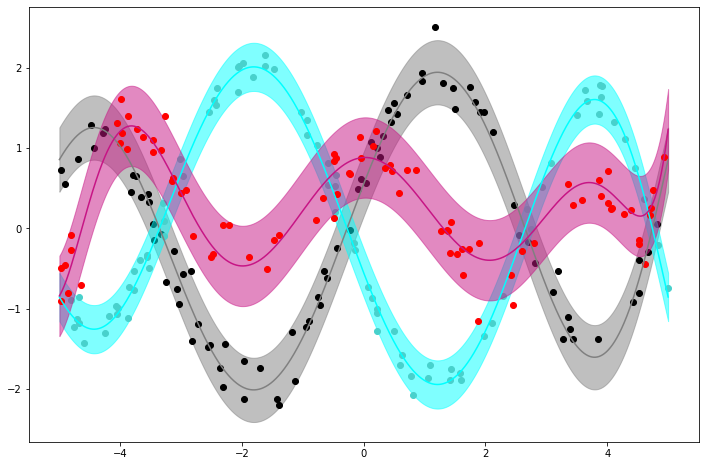

In [141]:
velocity_override = 5
setup_inst = problem_setups.quad_2d_sys_1d_inp_res(velocity_override)
regions = setup_inst["regions"]
s_start_limit, s_end_limit = setup_inst["x_start_limit"], setup_inst["x_end_limit"]
gp_input_mask = setup_inst["gp_input_mask"]
delta_input_mask = setup_inst["delta_input_mask"]
n_u = setup_inst["n_u"]
num_samples = 250
viz = True
noise_std_devs = [0.05, 0.07, 0.02]
scale_poly = 1
noise_std_devs = [0.1, 0.075, 0.125]
# noise_std_devs = [0.1, 0.075, 0.125]
scale_poly = 4
noise_std_devs = [0.2, 0.15, 0.25]

# 0 idx is np.polynomial.polynomial.polyfromroots([-0.2, -0.05, 0, 0.2]), 1 idx is np.polynomial.polynomial.polyfromroots([-0.25, -0.05, 0.15, 0.23])
poly_coeffs = [np.array([0.0075, -0.0425, -0.2   ,  1.][::-1])*5, 
               np.array([0.04, -0.22, -0.1 ,  1.    ][::-1])*5, np.array([4.3125e-04,  5.6000e-03, -6.7000e-02, -8.0000e-02,  1.0000e+00][::-1])*5]
poly_coeffs = [np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               -np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               np.array([3.48167424e-05,  2.29572396e-05, -1.92304178e-03, -5.29264039e-04,  3.35480619e-02,  5.82899495e-04, -1.87669116e-01,  9.30450457e-03,  2.20458632e-01])]
# poly_coeffs = [[1, 0, 0], [7, 0, 0]]

ds_inst_in = ds_utils.test_1d_op_1d_inp_poly(regions=regions, poly_coeffs=poly_coeffs,
                                             start_limit=setup_inst["gpinp_subset_lim_lb"], end_limit=setup_inst["gpinp_subset_lim_ub"], gp_input_mask=gp_input_mask,
                                             delta_input_mask=delta_input_mask, n_u=n_u, num_points=num_samples,
                                             noise_vars=[noise_std_dev ** 2 for noise_std_dev in noise_std_devs],
                                             no_viz=not viz, fineness_param=(200,), scale_poly=scale_poly)

Training piecewise GP
Training model: 1 for region: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 229.98it/s]


final loss: 0.14409756660461426, lengthscale: 1.56847 noise variance (sigma**2): 0.04394, noise std dev (sigma): 0.20962
Training model: 1 for region: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 354.11it/s]


final loss: -0.18807432055473328, lengthscale: 1.40862 noise variance (sigma**2): 0.01942, noise std dev (sigma): 0.13934
Training model: 1 for region: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 354.24it/s]


final loss: 0.32068389654159546, lengthscale: 0.71879 noise variance (sigma**2): 0.06463, noise std dev (sigma): 0.25422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 169.05it/s]


final loss: 1.4983490705490112, lengthscale: 0.32392 noise variance (sigma**2): 1.15079, noise std dev (sigma): 1.07275
Training global GP


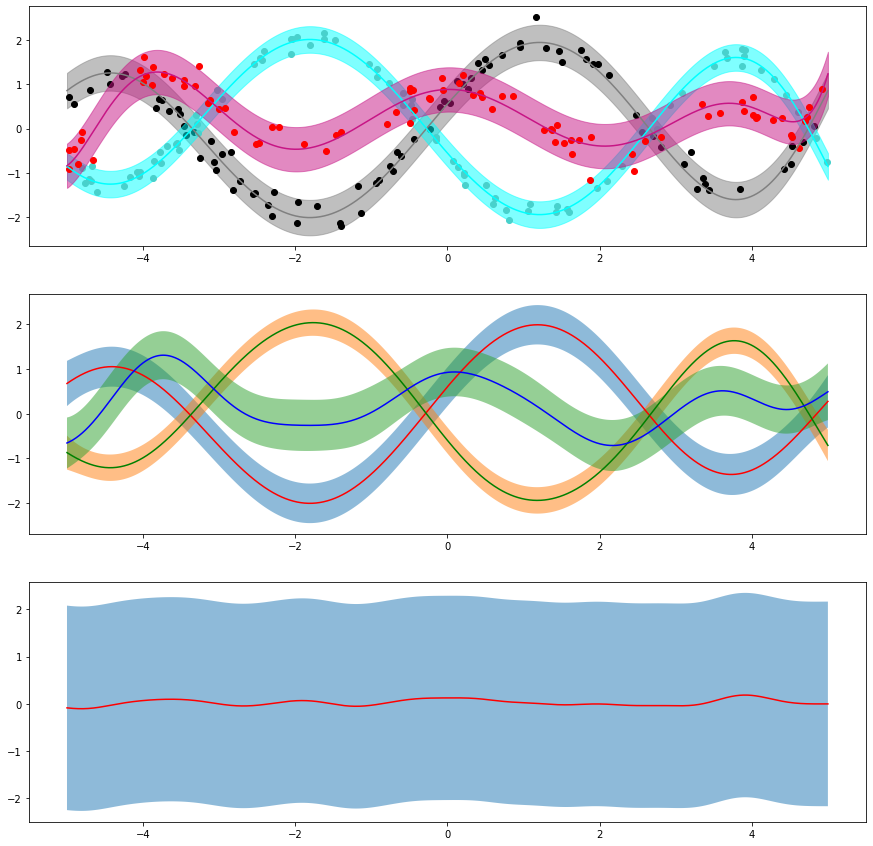

In [142]:
trained_gp_viz = True
train_verbose = True
return_error_attrs = False
seed = None
fineness_param = (75,)
num_iter = 350
true_only = False
terminate_by_change = False
save_to_file = False
load_from_file = False
file_save_name = "res_1d_poly_gp"
file_load_name = "res_1d_poly_gp"

pw_gp_wrapped, global_gp_wrapped, gp_ds_inst = gp_wrappers.train_global_n_pw(ds_inst_in, regions, viz=trained_gp_viz, verbose=train_verbose, return_error_attrs=return_error_attrs,
                                                                             seed=seed, fineness_param=fineness_param, num_iter=num_iter, true_only=true_only,
                                                                             terminate_by_change=terminate_by_change, save_to_file=save_to_file, load_from_file=load_from_file,
                                                                             file_save_name=file_save_name, file_load_name=file_load_name)

## Quad 2D residual

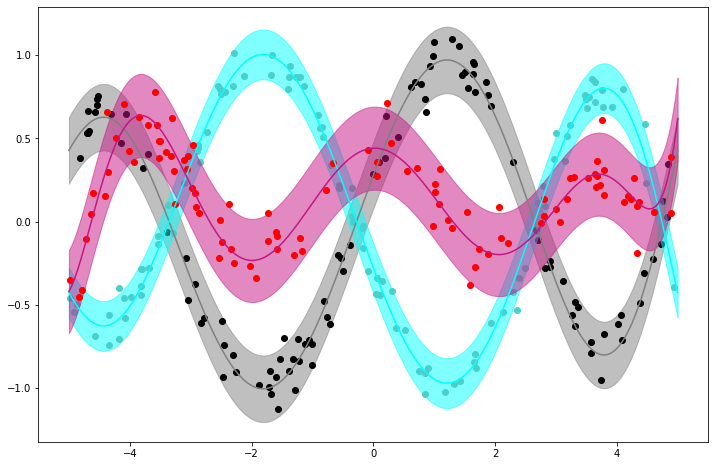

In [151]:
velocity_override = 5
setup_inst = problem_setups.quad_2d_sys_1d_inp_res(velocity_override)
regions = setup_inst["regions"]
s_start_limit, s_end_limit = setup_inst["x_start_limit"], setup_inst["x_end_limit"]
gp_input_mask = setup_inst["gp_input_mask"]
delta_input_mask = setup_inst["delta_input_mask"]
n_u = setup_inst["n_u"]
num_samples = 300
viz = True
noise_std_devs = [0.05, 0.07, 0.02]
scale_poly = 2
noise_std_devs = [0.1, 0.075, 0.125]
# noise_std_devs = [0.1, 0.075, 0.125]
# scale_poly = 2

# 0 idx is np.polynomial.polynomial.polyfromroots([-0.2, -0.05, 0, 0.2]), 1 idx is np.polynomial.polynomial.polyfromroots([-0.25, -0.05, 0.15, 0.23])
poly_coeffs = [np.array([0.0075, -0.0425, -0.2   ,  1.][::-1])*5, 
               np.array([0.04, -0.22, -0.1 ,  1.    ][::-1])*5, np.array([4.3125e-04,  5.6000e-03, -6.7000e-02, -8.0000e-02,  1.0000e+00][::-1])*5]
poly_coeffs = [np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               -np.array([-5.86024026e-05, -9.09922063e-05,  4.17839279e-03,  5.46798390e-03, -8.74124645e-02, -7.68274967e-02,  4.89430419e-01,  1.38718238e-01]),
               np.array([3.48167424e-05,  2.29572396e-05, -1.92304178e-03, -5.29264039e-04,  3.35480619e-02,  5.82899495e-04, -1.87669116e-01,  9.30450457e-03,  2.20458632e-01])]
# poly_coeffs = [[1, 0, 0], [7, 0, 0]]

ds_inst_in = ds_utils.test_1d_op_1d_inp_poly(regions=regions, poly_coeffs=poly_coeffs,
                                             start_limit=setup_inst["gpinp_subset_lim_lb"], end_limit=setup_inst["gpinp_subset_lim_ub"], gp_input_mask=gp_input_mask,
                                             delta_input_mask=delta_input_mask, n_u=n_u, num_points=num_samples,
                                             noise_vars=[noise_std_dev ** 2 for noise_std_dev in noise_std_devs],
                                             no_viz=not viz, fineness_param=(200,), scale_poly=scale_poly)

Training piecewise GP
Training model: 1 for region: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 318.70it/s]


final loss: -0.6207471489906311, lengthscale: 1.54715 noise variance (sigma**2): 0.00984, noise std dev (sigma): 0.09919
Training model: 1 for region: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 314.01it/s]


final loss: -0.7860745787620544, lengthscale: 1.91455 noise variance (sigma**2): 0.00679, noise std dev (sigma): 0.08243
Training model: 1 for region: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 309.53it/s]


final loss: -0.32945457100868225, lengthscale: 0.64710 noise variance (sigma**2): 0.01932, noise std dev (sigma): 0.13898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:01<00:00, 212.16it/s]


final loss: 0.8322794437408447, lengthscale: 0.75148 noise variance (sigma**2): 0.30340, noise std dev (sigma): 0.55082
Training global GP


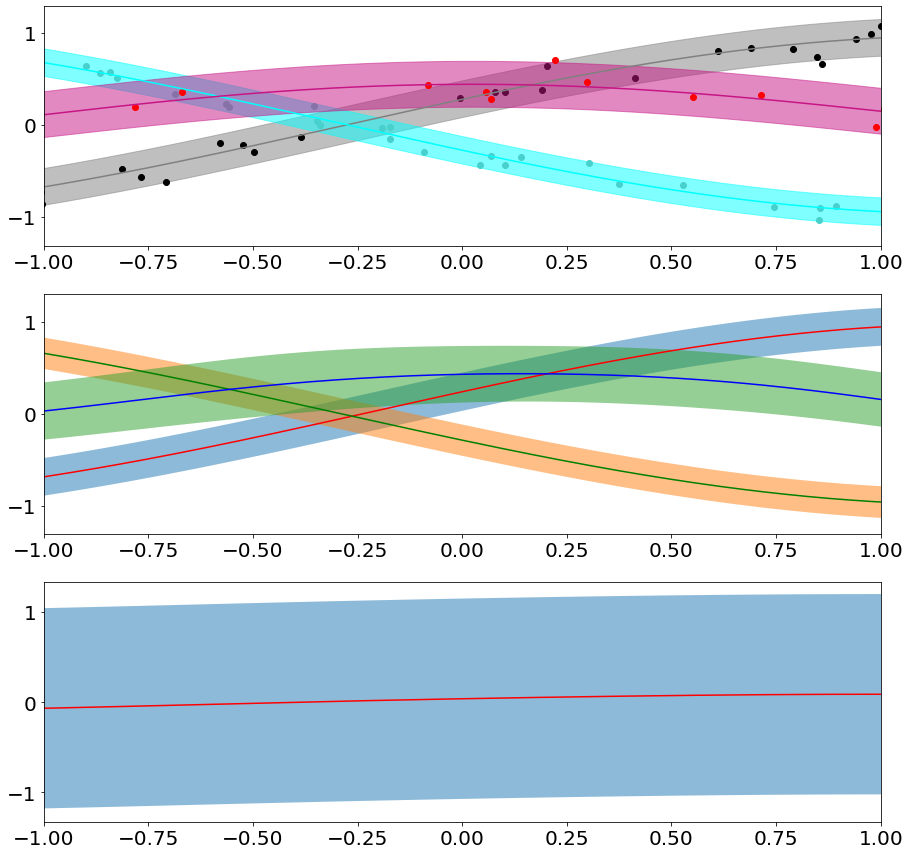

In [152]:
trained_gp_viz = True
train_verbose = True
return_error_attrs = False
seed = None
fineness_param = (75,)
num_iter = 350
true_only = False
terminate_by_change = False
save_to_file = False
load_from_file = False
file_save_name = "res_1d_poly_gp"
file_load_name = "res_1d_poly_gp"

pw_gp_wrapped, global_gp_wrapped, gp_ds_inst = gp_wrappers.train_global_n_pw(ds_inst_in, regions, viz=trained_gp_viz, verbose=train_verbose, return_error_attrs=return_error_attrs,
                                                                             seed=seed, fineness_param=fineness_param, num_iter=num_iter, true_only=true_only,
                                                                             terminate_by_change=terminate_by_change, save_to_file=save_to_file, load_from_file=load_from_file,
                                                                             file_save_name=file_save_name, file_load_name=file_load_name)